<a href="https://colab.research.google.com/github/wikistat/AI-Frameworks/blob/master/IntroductionDeepReinforcementLearning/Policy_Gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [IA Frameworks](https://github.com/wikistat/AI-Frameworks) - Introduction to Deep Reinforcement Learning 

<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" width=400, style="max-width: 150px; display: inline"  alt="Wikistat"/></a>
<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" width=400,  style="float:right;  display: inline" alt="IMT"/> </a>
    
</center>

# Part 2 : Policy Gradient Algorithm

The objectives of this notebook are the following : 

* Implement Hard-Coded And Neural network policy to solve the *CartPole* Game 
* Implement Policy gradient algorithm to solve the *CartPole* Game 


# Files & Data (Google Colab)

If you're running this notebook on Google colab, you do not have access to the `solutions` folder you get by cloning the repository locally. 

The following lines will allow you to build the folders and the files you need for this TP.

**WARNING 1** Do not run this line localy.
**WARNING 2** The magic command `%load` does not work work on google colab, you will have to copy-paste the solution on the notebook.

In [1]:
! mkdir solution
! wget -P solution https://github.com/wikistat/AI-Frameworks/raw/master/IntroductionDeepReinforcementLearning/solutions/

mkdir: solution: File exists
zsh:1: command not found: wget


# Import librairies

In [2]:
import numpy as np
import random
import math
from tqdm import tqdm

# To plot figures and animations
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML


#Tensorflow/Keras utils
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.initializers as ki
import tensorflow.keras.optimizers as ko
import tensorflow.keras.backend as K


# Gym Library
import gym

The following functions enable to build a video from a list of images. <br>
They will be used to build video of the game you will played.

In [3]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

# AI Gym Librairie
<a href="https://gym.openai.com/" ><img src="https://gym.openai.com/assets/dist/home/header/home-icon-54c30e2345.svg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

In this notebook we will be using [OpenAI gym](https://gym.openai.com/), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with.

# A simple environment: the Cart-Pole

## Description
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.

### Observation

Num | Observation | Min | Max
---|---|---|---
0 | Cart Position | -2.4 | 2.4
1 | Cart Velocity | -Inf | Inf
2 | Pole Angle | ~ -41.8&deg; | ~ 41.8&deg;
3 | Pole Velocity At Tip | -Inf | Inf

### Actions

Num | Action
--- | ---
0 | Push cart to the left
1 | Push cart to the righ&t

Note: The amount the velocity is reduced or increased is not fixed as it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it

### Reward
Reward is 1 for every step taken, including the termination step

### Starting State
All observations are assigned a uniform random value between ±0.05

### Episode Termination
1. Pole Angle is more than ±12°
2. Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
3. Episode length is greater than 200

### Solved Requirements
Considered solved when the average reward is greater than or equal to 195.0 over 100 consecutive trials.

The description above if part of the official description of this environemtn. Read full description [here](https://github.com/openai/gym/wiki/CartPole-v0).

The following command will load the `CartPole` environment.

In [4]:
env = gym.make("CartPole-v0")

In [5]:
env.reset()
img = env.render(mode = "rgb_array")
env.close()
print("Environemnt is a %dx%dx%d images" %img.shape)

Environemnt is a 400x600x3 images


(-0.5, 599.5, 399.5, -0.5)

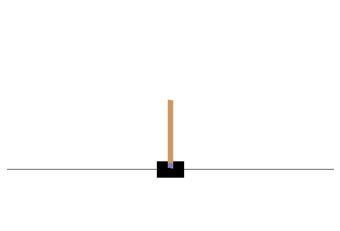

In [6]:
plt.imshow(img)
plt.axis("off")

If you have forgotten how the `CartPole` environment works, open the `Deep_Q_Learning_CartPole.ipynb` notebook to run explanation's cell.

# Hard coded policy

How can we make the poll remain upright? We will need to define a _policy_ for that. 

This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

Let's first implement **Hard Coded policies**, *i.e.* simple rules that defines which action to takes according to the parameters.

In [7]:
def run_one_episode(policy, return_frames=False):
    frames = []
    observation = env.reset()    
    reward_episod = 0    
    done = False
    while not(done):
        action = policy(observation)
        observation, reward, done, _ = env.step(action)
        reward_episod += reward
        if return_frames:
            img = env.render(mode = "rgb_array")
            env.close()
            frames.append(img)
    return reward_episod, frames

In [8]:
def play_games(policy, n_games=100):
    all_reward_sum = []   
    n_game = 0          
    while n_game < n_games:
        reward_episod, _ = run_one_episode(policy)
        if n_game %10 == 0:
            print("Game played : %d. Mean and Standart deviation's reward for the last 10 episode: %.1f - %.1f" %(n_game, np.mean(all_reward_sum[-10:]), np.std(all_reward_sum[-10:])) )
        all_reward_sum.append(reward_episod)
        n_game += 1
    print("Over %d episodes, mean reward: %.1f, std : %.1f" %(n_games, np.mean(all_reward_sum), np.std(all_reward_sum)))

## Random policy

Let's start with a completly random policy and see how much time the poll will remain upright over 100 episodes.

In [9]:
def policy_random(state):
    return env.action_space.sample()
play_games(policy = policy_random)

Game played : 0. Mean and Standart deviation's reward for the last 10 episode: nan - nan
Game played : 10. Mean and Standart deviation's reward for the last 10 episode: 20.1 - 8.2
Game played : 20. Mean and Standart deviation's reward for the last 10 episode: 22.4 - 8.8
Game played : 30. Mean and Standart deviation's reward for the last 10 episode: 18.8 - 11.3
Game played : 40. Mean and Standart deviation's reward for the last 10 episode: 32.4 - 12.8
Game played : 50. Mean and Standart deviation's reward for the last 10 episode: 21.0 - 11.8
Game played : 60. Mean and Standart deviation's reward for the last 10 episode: 24.0 - 13.2
Game played : 70. Mean and Standart deviation's reward for the last 10 episode: 23.4 - 10.1
Game played : 80. Mean and Standart deviation's reward for the last 10 episode: 18.9 - 8.8
Game played : 90. Mean and Standart deviation's reward for the last 10 episode: 19.4 - 9.8
Over 100 episodes, mean reward: 21.6, std : 11.1


/Users/brendanguillouet/anaconda3/envs/AIF/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/brendanguillouet/anaconda3/envs/AIF/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/brendanguillouet/anaconda3/envs/AIF/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/brendanguillouet/anaconda3/envs/AIF/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/brendanguillouet/anaconda3/envs/AIF/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### Visualize a complete game

Let's run one pisode with his random policy and save all images representing the environment at each step.

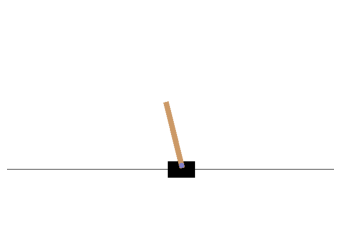

In [10]:
reward_episod, frames = run_one_episode(policy = policy_random, return_frames=True)
HTML(plot_animation(frames).to_html5_video())

### Simple strategy

Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and _vice versa_. Let's see if that works.

**Exercise** implement this policy and play 100 games with this policy. What are the means and std deviation of the reward sum over the 100 games?

In [11]:
# %load solutions/pg_simple_policy.py
def simple_policy(observation):
    angle = observation[2]
    action = 0 if angle < 0 else 1
    return action

In [12]:
play_games(policy = simple_policy)

Game played : 0. Mean and Standart deviation's reward for the last 10 episode: nan - nan
Game played : 10. Mean and Standart deviation's reward for the last 10 episode: 44.1 - 11.0
Game played : 20. Mean and Standart deviation's reward for the last 10 episode: 42.5 - 8.1
Game played : 30. Mean and Standart deviation's reward for the last 10 episode: 42.2 - 7.7
Game played : 40. Mean and Standart deviation's reward for the last 10 episode: 39.5 - 8.0
Game played : 50. Mean and Standart deviation's reward for the last 10 episode: 43.1 - 8.2
Game played : 60. Mean and Standart deviation's reward for the last 10 episode: 39.6 - 8.7
Game played : 70. Mean and Standart deviation's reward for the last 10 episode: 43.2 - 6.4
Game played : 80. Mean and Standart deviation's reward for the last 10 episode: 43.9 - 8.2
Game played : 90. Mean and Standart deviation's reward for the last 10 episode: 45.2 - 10.2
Over 100 episodes, mean reward: 42.5, std : 8.8


/Users/brendanguillouet/anaconda3/envs/AIF/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/brendanguillouet/anaconda3/envs/AIF/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/brendanguillouet/anaconda3/envs/AIF/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/brendanguillouet/anaconda3/envs/AIF/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/brendanguillouet/anaconda3/envs/AIF/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


**Q** What can you say about this strategy?

**Exercise** Vizualize a complete game:

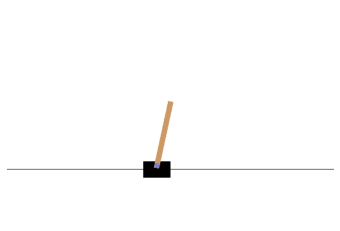

In [13]:
reward_episod, frames = run_one_episode(policy = simple_policy, return_frames=True)
HTML(plot_animation(frames).to_html5_video())

# Neural Network Policies

Let's create a neural network to build a better policy.

This network will take the observations as inputs, and output the probability of the action to take for each observation. <br>

In the case of the Cart-Pole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability `p` of the action 1 (right), and of course the probability of action 0 (right) will be `1 - p`.

Let's first see how this neural network policy work without training it and then let's try to learn the simple policy define above.

## The architecture

Because this problem is simple, we can define a very simple architecture for our neural network.<bR> 
    
Here it's simple MLP with 1 hidden layer and four neurons.

In [14]:
# Specify the network architecture
n_inputs = 4  # == env.observation_space.shape[0]
n_hidden = 9  # it's a simple task, we don't need more than this
n_outputs = 1 # only outputs the probability of accelerating right

# Build the neural network
policy_network=km.Sequential()
policy_network.add(kl.Dense(n_hidden, input_shape = (n_inputs,), activation = "relu"))
policy_network.add(kl.Dense(n_outputs, activation = "sigmoid"))
policy_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 45        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10        
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________


Note that the model is not compile so far, no loss function is defined. 

## Policy from a neural network
We can now easily predict the probability of both actions given the observation.

**Exercise** Define a function to choose the action to take from an observation and the neural network.

In [15]:
# %load solutions/pg_neural_network_policy.py
def neural_network_policy(observation, model):
    p_right = model.predict(np.expand_dims(observation,axis=0))
    action = 1 if p_right>0.5 else 0
    return action

***NB*** :  In this particular environment, the past actions and observations can safely be ignored, since each observation contains the environment's full state. If there were some hidden state then you may need to consider past actions and observations in order to try to infer the hidden state of the environment. 

For example, if the environment only revealed the position of the cart but not its velocity, you would have to consider not only the current observation but also the previous observation in order to estimate the current velocity. <br> Another example:  if the observations are noisy: you may want to use the past few observations to estimate the most likely current state. Our problem is thus as simple as can be: the current observation is noise-free and contains the environment's full state.

## Random neural network policy.
Let's see how this neural network policy perform.



In [ ]:
play_games(policy = lambda obs : neural_network_policy(obs, model=policy_network), n_games=10)

/Users/brendanguillouet/anaconda3/envs/AIF/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/brendanguillouet/anaconda3/envs/AIF/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/brendanguillouet/anaconda3/envs/AIF/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/brendanguillouet/anaconda3/envs/AIF/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/brendanguillouet/anaconda3/envs/AIF/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Game played : 0. Mean and Standart deviation's reward for the last 10 episode: nan - nan


Let's randomly initialize this policy neural network and use it to play one game:

In [ ]:
reward_episod, frames = run_one_episode(policy = lambda obs : neural_network_policy(obs, model=policy_network), return_frames=True)
HTML(plot_animation(frames).to_html5_video())

The neural network is working. But it's still acting randomly because we do not train the neural network. Let's try to make it learn better policy.

## Learn a given policy

In this part we will train the neural network in order that it learns the simple strategy we hard coded before : if the pole is tilting to the left, then push the cart to the left, and _vice versa_.

We start by defining the neural network policy with the same architecture than before. <br>
This time we compile this network in order to learn the wanted behaviour<br>

**Exercicse** Compile the model with the good loss for the given problem.

At each iteration we will :

* Train the network over observations we have.
    *  These observation will be the inputs, and the target will be the expected behavior.
* Predict the action according to the neural network policy.

**Question** : On the code below, looks how the actions is chosen. Why do we follow this method?

In [ ]:
class PG:

    def __init__(self):
        # Environment
        self.env = gym.make("CartPole-v0")
        self.dim_input = self.env.observation_space.shape[0]

        # Parameters
        self.model = self.init_model()

    def init_model(self):

        # Build the neural network
        policy_network = km.Sequential()
        policy_network.add(kl.Dense(9, input_shape=(self.dim_input,), activation="relu"))
        policy_network.add(kl.Dense(1, activation="sigmoid"))
        policy_network.compile(loss=??, optimizer=ko.Adam(), metrics=['accuracy'])
        return policy_network

    def play_one_episode(self):
        # TODO
        return train_data

    def train(self):
        n_episode = 1000
        for iteration in tqdm(range(n_episode)):
            train_data = self.play_one_episode()
            n_step = len(train_data)
            target = np.array([x[1] for x in train_data]).reshape((n_step, 1))
            observations = np.array([x[0] for x in train_data])
            self.model.train_on_batch(observations, target)

In [ ]:
pg = PG()
pg.train()

In [ ]:
# %load solutions/pg_learn_given_policy.py
class PG:

    def __init__(self):
        # Environment
        self.env = gym.make("CartPole-v0")
        self.dim_input = self.env.observation_space.shape[0]

        # Parameters
        self.model = self.init_model()

    def init_model(self):

        # Build the neural network
        policy_network = km.Sequential()
        policy_network.add(kl.Dense(9, input_shape=(self.dim_input,), activation="relu"))
        policy_network.add(kl.Dense(1, activation="sigmoid"))
        policy_network.compile(loss='binary_crossentropy', optimizer=ko.Adam(), metrics=['accuracy'])
        return policy_network

    def play_one_episode(self):
        train_data = []
        observation = self.env.reset()
        action = 0 if observation[2] < 0 else 1
        done = False
        while not done:
            observation, reward, done, _ = self.env.step(action)
            action = 0 if observation[2] < 0 else 1
            train_data.append([observation, action])
        return train_data

    def train(self):
        n_episode = 1000
        for iteration in tqdm(range(n_episode)):
            train_data = self.play_one_episode()
            n_step = len(train_data)
            target = np.array([x[1] for x in train_data]).reshape((n_step, 1))
            observations = np.array([x[0] for x in train_data])
            self.model.train_on_batch(observations, target)

In [ ]:
play_games(policy = lambda obs : neural_network_policy(obs, model=pg.model), n_games=10)

In [ ]:
reward_episod, frames = run_one_episode(policy = lambda obs : neural_network_policy(obs, model=pg.model), return_frames=True)
HTML(plot_animation(frames).to_html5_video())

Looks like it learned the policy correctly! <br>

Let's now reach our final target : The neural network has to find a better policy by its own.

# Policy Gradients

The idea behind *Policy Gradients* its quite simple : The _Policy Gradients_ algorithm tackles this problem by first playing multiple games, then making the actions in good games slightly more likely, while actions in bad games are made slightly less likely. First we play, then we go back and think about what we did.

### Algorithm

* Run an episode untill it's done and save at each iteration the observation, action and reward.
* When an episode it's done. Compute the discounted rewards for all the episode, and save it.
* If you have done *batch_size=50* episodes train your model on this batch.
* Stop if you have reach *num episodes* or *goal* target.


### Parameters

| Variable  | Value  | Description  | 
|---|---|---|
|Gamma   | 0.99  | The discounted rate apply for the discounted reward  |
|batch_size  | 50   | Number of episode to run before training model on a batch of episode  |
| Num episodes | 10.000   | Maximum number of episode to run before stopping the training  | 
| goal | 190  | Number of step to achieve on one episode to stop the training.  |

Those parameters are fixed for this TP, they are common value for this kind of problem based on experiences. They are not definitive nor results or any research.

### Discounted rewards


To train this neural network we will then used the observation of the experiences as an inputs and the actions taken as an output.

But how do we provide to the neural network the information the choosen actions  was good or bad?
The problem is that most actions have delayed effects, so when you win or lose points in a game, it is not clear which actions contributed to this result: was it just the last action? Or the last 10? Or just one action 50 steps earlier? <br>
This is called the _credit assignment problem_.


To tackle this problem, a common strategy is to evaluate an action based on the sum of all the rewards that come after it, usually applying a discount rate r at each step. It's call the **discounted rewards**

$$ R_t = \sum_{i=0}^{\infty}\gamma^i r_{t+i}$$



This rate will the be applied to the loss function of the neural network :
* A high discounted reward will lead to higher gradient which will increase the importance of this action
* A low  discounted reward will lead to lower gradient which will decrease the importance of this action
 

**Exercise** : Implement the discount_rewards function.

In [ ]:
def discount_rewards(r, gamma=0.99):
    """Takes 1d float array of rewards and computes discounted reward
    e.g. f([1, 1, 1], 0.99) -> [2.9701, 1.99, 1]
    """
    TODO
    return discounted_rewards

In [ ]:
# %load solutions/discount_rewards.py
def discount_rewards(rewards, gamma=0.99):
    """Takes 1d float array of rewards and computes discounted reward
    e.g. f([1, 1, 1], 0.99) -> [2.9701, 1.99, 1]
    """
    n_rewards = len(rewards)
    discounted_rewards = [0 for _ in range(n_rewards)]
    for i in range(n_rewards):
        for j,r in enumerate(rewards[i:]):
            discounted_rewards[i]+= math.pow(gamma,j)*r
    return discounted_rewards

In [ ]:
assert np.all(discount_rewards([1,1,1], gamma=0.99) == [2.9701, 1.99, 1])
assert np.all(discount_rewards([3,2,1],gamma=0.99) == [5.960100000000001, 2.99, 1.0])

## Architecture & Loss Function

As before we will define a very simple architecture to our neural network : A MLP with only one hidden layer and 8 neurons.

We have to be aware here that the neural network will have two different behaviour :

* For training: the model will take two information as an input : The observations (to predict the action), and the discounted rate (also call advantages) that will be applied on the loss function.
* For prediction : the model will take only the observations as an input to predict the action.

So we have to define a neural network that can either handle one or two inputs! 

In keras we define it that way : we define the layers, and we create two models (for training and prediction) that will share the same layers and weight.

We will also implement the loss function, which is weighted binary cross entropy, where the weight are the discounted rated computed from the rewards

Here is how we implement it : (Make sure you understand it!) 

In [ ]:
def generate_train_predict_network(hidden_layer_neurons, dimen, lr = 1e-2, initializer = ki.VarianceScaling()):
    num_actions = 1
    inp = kl.Input(shape=dimen,name="input_x")
    adv = kl.Input(shape=[1], name="advantages")
    x = kl.Dense(hidden_layer_neurons,  activation="relu",
                     use_bias=False,
                     kernel_initializer=initializer,
                     name="dense_1")(inp)
    out = kl.Dense(num_actions,
                       activation="sigmoid",
                       kernel_initializer=initializer,
                       use_bias=False,
                       name="out")(x)

    model_train = km.Model(inputs=[inp, adv], outputs=out)
    model_predict = km.Model(inputs=[inp], outputs=out)

    def my_custom_loss(y_true, y_pred):
        log_lik = - (y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))
        return K.mean(log_lik * adv, keepdims=True)

    model_train.compile(loss=my_custom_loss, optimizer=ko.Adam(lr))
    return model_train, model_predict


This function is very similar than the code use before to compute how our model perform.

In [ ]:
# See our trained bot in action
def score_model(model, num_tests, dimen, render=False):
    scores = []
    for num_test in range(num_tests):
        observation = env.reset()
        reward_sum = 0
        while True:
            if render:
                env.render()

            state = np.reshape(observation, [1, dimen])
            predict = model.predict([state])[0]
            action = 0 if predict>0.5 else 1
            observation, reward, done, _ = env.step(action)
            reward_sum += reward
            if done:
                break
        scores.append(reward_sum)
    env.close()
    return np.mean(scores)

### PG class

Let's know write our algorithm without a `PG` class.

Firs let's have a look at the `train` function which can be described with the following psuedo-code:

* Initialize all variables and envrionment
* While number of episode max is not reached or if our ***goal*** is not achieve:
    * Run one step within the environment
    * If we ended an episode:
        * If we have reached ***batch_size*** episode generated: 
            * Train the episode
        * If we have reached the ***print_every*** number of episode generated: 
            * print score and see if we have achieves our ***goal*** on the last ***n_test*** episode
        * Increase number of episodes
        
**Exercise**  Complete the class below to in order to train the neural network with PG policy.

1. Pay attention to all the parameters define in the init and make sure you understand it.
2. Look at the train function to understand how the "pseudo-code" should workK
3. Go inside *run_one_step_epsiode* and the *run_one_batch_train* functions and complete the code where you'll find a TODO mark in order to make the function train work!

In [ ]:
class PG:

    def __init__(self, gamma = .99, batch_size = 50, num_episodes = 10000, goal = 190, n_test = 10, print_every = 100):

        self.gamma = gamma      # -> Discounted reward
        self.batch_size = batch_size  # -> Size of episode before training on a batch

        # Stop factor
        self.num_episodes = num_episodes # Max number of iterations
        self.goal = goal                 # Stop if our network achieve this goal over *n_test*
        self.n_test = n_test             # Number of test to run to evaluate if our goal si achieve.

        self.print_every = print_every  #Number of episode before trying if our model perform well.

    def run_one_step_episode(self, observation):
        # Generate state and action for the current iteration
        TODO
        
        # Append the observations and outputs for learning to the states and actions placeholder
        TODO
        
        # Determine the new outcome of the action generated
        TODO
        
        # Append the rewards for learning to the rewards place older
        TODO

        # If the episode if Over
        if done:
            # Computed the discounted rewards for this episode
            TODO

            # Append the discounted rewards for learning and reset the rewards placeholder for the ne episode
            TODO
        return observation, reward, done
    

    def run_one_batch_train(self):
        # Normalize the discounted rewards
        self.discounted_rewards -= self.discounted_rewards.mean()
        self.discounted_rewards /= self.discounted_rewards.std()
        self.discounted_rewards = self.discounted_rewards.squeeze()
        
        # Train the "model_train" models on the batch of episodes generated and save loss to the losses placehoder
        # Use the "train_on_batch" method from keros to train the model on a single batch
        TODO
        
        # Do not forget to clear place holder variable for next batch train
        TODO

    def print_status(self, num_episode, reward_sum, score):
        # Print status
        print(
            "Average reward for training episode {}: {:0.2f} Test Score of {:d} episode: {:0.2f} Loss: {:0.6f} ".format(
                (num_episode + 1), reward_sum / self.print_every, self.n_test,
                score,
                self.losses[-1]))
        return score

    def train(self):

        # Setting up our environment
        observation = env.reset()
        self.dimen = env.reset().shape[0]


        # Placeholders for our observations, outputs and rewards
        self.states = np.empty(0).reshape(0, self.dimen)
        self.actions = np.empty(0).reshape(0, 1)
        self.rewards = np.empty(0).reshape(0, 1)
        self.discounted_rewards = np.empty(0).reshape(0, 1)
        self.losses = []


        num_episode = 0
        reward_sum = 0 # # For display info

        self.model_train, self.model_predict = generate_train_predict_network(hidden_layer_neurons=9, dimen=(self.dimen,))

        while num_episode < self.num_episodes:
            observation, reward, done = self.run_one_step_episode(observation)
            reward_sum += reward

            # If the episode if Over and ifwe have reach 50=batch_size episodes run training for the build batch
            if done:
                if (num_episode + 1) % self.batch_size == 0:
                    self.run_one_batch_train()

                # Print results periodically
                if (num_episode + 1) % self.print_every == 0:
                    score = score_model(self.model_predict, self.n_test, self.dimen)
                    self.print_status(num_episode, reward_sum, score)
                    reward_sum = 0
                    if score >= self.goal:
                        print("Solved in {} episodes!".format(num_episode))
                        break

                num_episode += 1
                observation = env.reset()

In [ ]:
# %load solutions/exercise_1_5.py
class PG:

    def __init__(self, gamma = .99, batch_size = 50, num_episodes = 10000, goal = 190, n_test = 10, print_every = 100):

        self.gamma = gamma      # -> Discounted reward
        self.batch_size = batch_size  # -> Size of episode before training on a batch

        # Stop factor
        self.num_episodes = num_episodes # Max number of iterations
        self.goal = goal           # Stop if our network achieve this goal over *n_test*
        self.n_test = n_test

        self.print_every = print_every #?Numbe rof episode before trying if our model perform well.

    def run_one_step_episode(self, observation):
        # Generate state and action for the current iteration
        state = np.reshape(observation, [1, self.dimen])
        predict = self.model_predict.predict([state])[0]
        action = 0 if random.uniform(0, 1) < predict else 1

        # Append the observations and outputs for learning
        self.states = np.vstack([self.states, state])
        self.actions = np.vstack([self.actions, action])

        # Determine the outcome of the action generated
        observation, reward, done, _ = env.step(action)


        ##Append the rewards for learning
        self.rewards = np.vstack([self.rewards, reward])

        # If the episode if Over
        if done:
            # Computed the discounted rewards for this episode
            discounted_rewards_episode = discount_rewards(self.rewards, self.gamma)

            # Append the discounted rewards for learning
            self.discounted_rewards = np.vstack([self.discounted_rewards, discounted_rewards_episode])
            self.rewards = np.empty(0).reshape(0, 1)

        return observation, reward, done

    def run_one_batch_train(self):
        # Normalize the discounted rewards
        self.discounted_rewards -= self.discounted_rewards.mean()
        self.discounted_rewards /= self.discounted_rewards.std()
        self.discounted_rewards = self.discounted_rewards.squeeze()

        actions_train = 1 - self.actions
        loss = self.model_train.train_on_batch([self.states, self.discounted_rewards], actions_train)
        self.losses.append(loss)

        # Clear out game variables
        self.states = np.empty(0).reshape(0, self.dimen)
        self.actions = np.empty(0).reshape(0, 1)
        self.discounted_rewards = np.empty(0).reshape(0, 1)

    def print_status(self, num_episode, reward_sum, score):
        # Print status
        print(
            "Average reward for training episode {}: {:0.2f} Test Score of {:d} episode: {:0.2f} Loss: {:0.6f} ".format(
                (num_episode + 1), reward_sum / self.print_every, self.n_test,
                score,
                self.losses[-1]))
        return score

    def train(self):

        # Setting up our environment
        observation = env.reset()
        self.dimen = env.reset().shape[0]


        # Placeholders for our observations, outputs and rewards
        self.states = np.empty(0).reshape(0, self.dimen)
        self.actions = np.empty(0).reshape(0, 1)
        self.rewards = np.empty(0).reshape(0, 1)
        self.discounted_rewards = np.empty(0).reshape(0, 1)
        self.losses = []


        num_episode = 0
        reward_sum = 0 # # For display info

        self.model_train, self.model_predict = generate_train_predict_network(hidden_layer_neurons=9, dimen=(self.dimen,))

        while num_episode < self.num_episodes:
            observation, reward, done = self.run_one_step_episode(observation)
            reward_sum += reward

            # If the episode if Over and ifwe have reach 50=batch_size episodes run training for the build batch
            if done:
                if (num_episode + 1) % self.batch_size == 0:
                    self.run_one_batch_train()

                # Print results periodically
                if (num_episode + 1) % self.print_every == 0:
                    score = score_model(self.model_predict, self.n_test, self.dimen)
                    self.print_status(num_episode, reward_sum, score)
                    reward_sum = 0
                    if score >= self.goal:
                        print("Solved in {} episodes!".format(num_episode))
                        break

                num_episode += 1
                observation = env.reset()

### Training

Let's train the model !

In [ ]:
pg = PG()
pg.train()

**Exercise** 

* Use the model to play 100 games and check how it performs compare to previous policy tested
* Register a video of a game and display it

In [ ]:
# %load solutions/exercise_1_6.py

In [ ]:
# %load solutions/exercise_1_7.py